<a href="https://colab.research.google.com/github/alanchan30/NeuralNetworkAnalyzation/blob/main/Neural_Network_Analyzation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# importing required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline

In [39]:
from sklearn.datasets import fetch_openml

# load the MNIST dataset (the original version with 28x28 images)
mnist = fetch_openml(name='mnist_784', version=1, as_frame=False)

In [40]:
# get the data and labels
X, y = mnist.data, mnist.target

# converts array with string labels into integers
y = y.astype(int)

# turn it into a pandas dataframe
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

In [41]:
# split the data into only 5% of what it actually is to reduce time
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.2, random_state = 42)

In [42]:
# train and test splitting of data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [43]:
# applying standard scaling to get optimized result, makes all numbers in same range
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [44]:
import numpy as np

class OwnMLPClassifier:
    def __init__(self, hidden_layer_sizes, max_iter, learning_rate):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = []
        self.biases = []

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exps / np.sum(exps, axis=-1, keepdims=True)

    def _leaky_relu(self, x, alpha=0.01):
        x = np.clip(x, -1000, 1000)
        return np.maximum(alpha * x, x)

    def _leaky_relu_derivative(self, x, alpha=0.01):
        dx = np.ones_like(x)
        dx[x < 0] = alpha
        return dx

    def _initialize_weights(self, input_size, output_size):
        for i in range(len(self.hidden_layer_sizes) + 1):
            if i == 0:
                layer_input_size = input_size
            else:
                layer_input_size = self.hidden_layer_sizes[i - 1]

            if i == len(self.hidden_layer_sizes):
                layer_output_size = output_size
            else:
                layer_output_size = self.hidden_layer_sizes[i]

            self.weights.append(np.random.randn(layer_input_size, layer_output_size))
            self.biases.append(np.zeros(layer_output_size))

    def fit(self, X, y):
        input_size = X.shape[1]
        output_size = len(np.unique(y))

        self._initialize_weights(input_size, output_size)

        if len(y.shape) == 1 or y.shape[1] == 1:
            from sklearn.preprocessing import OneHotEncoder
            encoder = OneHotEncoder(sparse_output=False, categories='auto')
            y = encoder.fit_transform(y.to_numpy().reshape(-1, 1))

        for _ in range(self.max_iter):
            activations = [X]
            for i in range(len(self.weights)):
                z = np.dot(activations[i], self.weights[i]) + self.biases[i]
                activations.append(self._leaky_relu(z))

            error = activations[-1] - y
            delta = error * self._leaky_relu_derivative(activations[-1])

            for i in range(len(self.weights) - 1, -1, -1):
                dW = np.dot(activations[i].T, delta)
                db = np.sum(delta, axis=0)
                self.weights[i] -= self.learning_rate * dW
                self.biases[i] -= self.learning_rate * db

                if i > 0:
                    delta = np.dot(delta, self.weights[i].T) * self._leaky_relu_derivative(activations[i])

    def predict(self, X, keep_vector):
        activations = [X]
        for i in range(len(self.weights)):
            z = np.dot(activations[i], self.weights[i]) + self.biases[i]
            if i == len(self.weights) - 1:
                activations.append(self.softmax(z))
            else:
                hidden_activations = self._leaky_relu(z)
                masked_activations = hidden_activations * keep_vector
                activations.append(masked_activations)
        return np.argmax(activations[-1], axis=1)

In [60]:
# neural network with 11 nodes in hidden layer
mlp = OwnMLPClassifier((11,), 5000, 0.01)
# train the model
mlp.fit(X_train,y_train)
# Define the binary vector to keep nodes at wanted indicies
keep_vector = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
# predict the model
mlp_pred = mlp.predict(X_test, keep_vector)

In [61]:
# see how the model performed, how good y_test did compared to our mlp_pred
print(classification_report(y_test, mlp_pred, zero_division=0))
print(confusion_matrix(y_test, mlp_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1126
           1       0.00      0.00      0.00      1274
           2       0.00      0.00      0.00      1106
           3       0.00      0.00      0.00      1144
           4       0.04      0.26      0.08      1104
           5       0.00      0.00      0.00      1039
           6       0.00      0.00      0.00      1096
           7       0.00      0.00      0.00      1149
           8       0.00      0.00      0.00      1090
           9       0.16      0.68      0.26      1072

    accuracy                           0.09     11200
   macro avg       0.02      0.09      0.03     11200
weighted avg       0.02      0.09      0.03     11200

[[   0    0    0    0  175    0    0    0    0  951]
 [   0    0    0    0 1273    0    0    0    0    1]
 [   0    0    0    1  867    0    0    0    0  238]
 [   0    0    0    0 1090    0    0    0    0   54]
 [   0    0    0    0  292   

In [62]:
def normalize_activations(activations):
    # Calculate the minimum and maximum values for each node
    min_vals = activations.min(axis=0)  # Minimum for each column (node)
    max_vals = activations.max(axis=0)  # Maximum for each column (node)

    # Apply min-max normalization
    normalized_activations = (activations - min_vals) / (max_vals - min_vals)

    return normalized_activations

# Use Leaky ReLU instead of ReLU if saturation is suspected
def get_hidden_layer_activations(model, X):
    hidden_layer_input = np.dot(X, model.weights[0]) + model.biases[0]
    hidden_layer_activations = np.where(hidden_layer_input > 0, hidden_layer_input, hidden_layer_input * 0.01)
    return hidden_layer_activations

# Extract the the hidden layer activations for the test set
hidden_layer_activations = get_hidden_layer_activations(mlp, X_test)

# Normalize the hidden layer activations
normalized_hidden_layer_activations = normalize_activations(hidden_layer_activations)

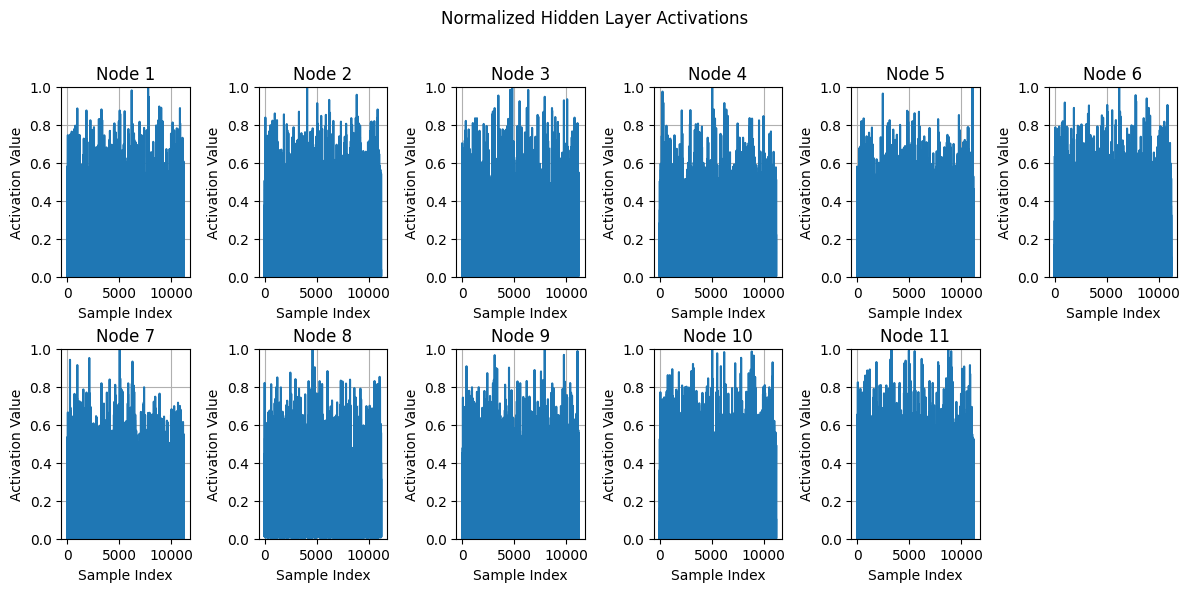

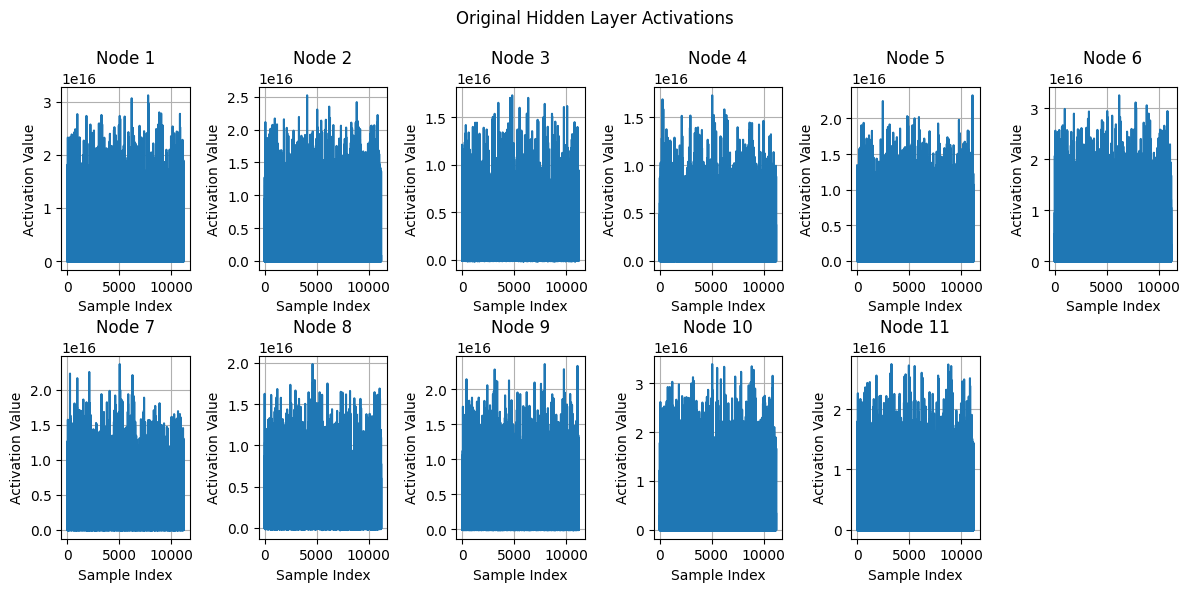

In [63]:
# Plot the normalized activations of the hidden layer (11 nodes)
plt.figure(figsize=(12, 6))
for i in range(normalized_hidden_layer_activations.shape[1]):  # Loop over each node in the hidden layer
  plt.subplot(2, 6, i+1)  # Create a subplot for each node
  plt.plot(normalized_hidden_layer_activations[:, i])  # Plot the activation for the node
  plt.title(f'Node {i+1}')  # Set the title of the subplot to the node number
  plt.xlabel('Sample Index')
  plt.ylabel('Activation Value')
  plt.ylim(0, 1)  # Set the y-axis limit to [0, 1]
  plt.grid(True)  # Add a grid to the plot
plt.tight_layout()  # Adjust the layout to prevent overlapping text
plt.suptitle('Normalized Hidden Layer Activations') # Big title for plots
plt.subplots_adjust(top=0.85)  # Adjust the title position
plt.show()  # Display the plot

print(" ") # Provide a space between plots

# Plot the original activations of the hidden layer (11 nodes)
plt.figure(figsize=(12, 6))
for i in range(hidden_layer_activations.shape[1]):  # Loop over each node in the hidden layer
  plt.subplot(2, 6, i+1)  # Create a subplot for each node
  plt.plot(hidden_layer_activations[:, i])  # Plot the activation for the node
  plt.title(f'Node {i+1}')  # Set the title of the subplot to the node number
  plt.xlabel('Sample Index')
  plt.ylabel('Activation Value')
  #plt.ylim(-10, 420)  # Set the y-axis limit to [-10, 410]
  plt.grid(True)  # Add a grid to the plot
plt.tight_layout()  # Adjust the layout to prevent overlapping text
plt.suptitle('Original Hidden Layer Activations') # Big title for plots
plt.subplots_adjust(top=0.85)  # Adjust the title position
plt.show()  # Display the plot

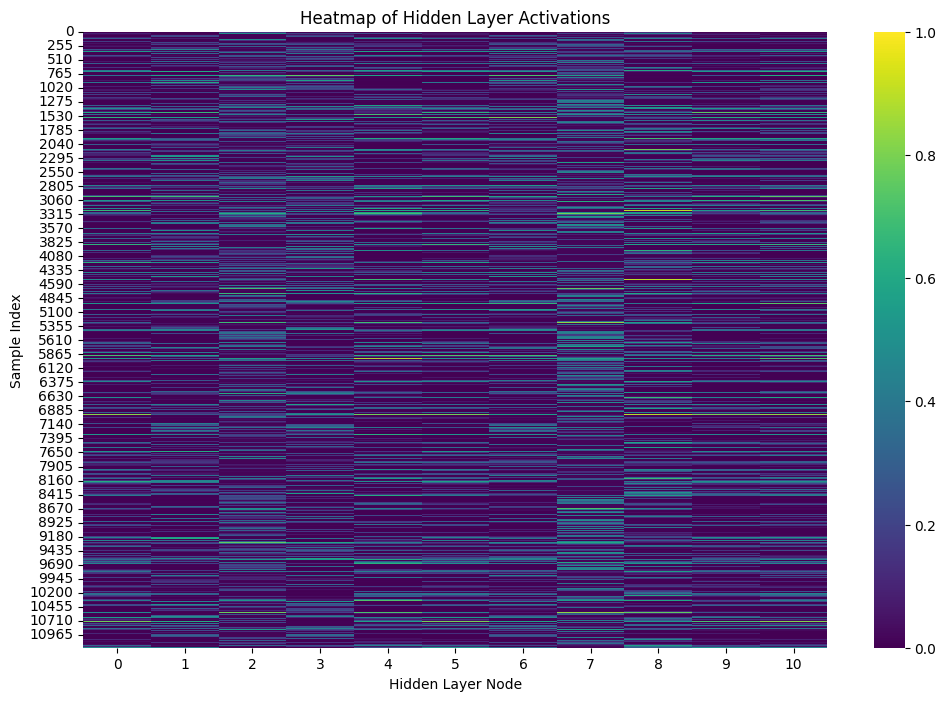

In [64]:
# Convert activations to a DataFrame for better visualization (optional but useful)
activation_df = pd.DataFrame(hidden_layer_activations)

# Create a min/max scaler to normalize the data values
scaler = MinMaxScaler()
activation_df_normalized = scaler.fit_transform(activation_df)
# activation_df_normalized = activation_df_normalized[:250]  # Limiting the normalized data values to just the first 250 sample indexes

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(activation_df_normalized, cmap='viridis', cbar=True)  # Customize cmap as needed
plt.xlabel("Hidden Layer Node")
plt.ylabel("Sample Index")
plt.title("Heatmap of Hidden Layer Activations")
plt.show()

In [66]:
# Define the binary vector to keep nodes at wanted indicies
keep_vector = np.array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0])

# Apply the binary vector to the normalized hidden layer activations
mlp_pred_modified = mlp.predict(X_test, keep_vector)

# Compare it with the original model's accuracy
print("Original Model")
print(classification_report(y_test, mlp_pred, zero_division=0))
print(confusion_matrix(y_test, mlp_pred))
print(" ")
print(" ")
print(" ")
print("Modified Model")
print(classification_report(y_test, mlp_pred_modified, zero_division=0))
print(confusion_matrix(y_test, mlp_pred_modified))

Original Model
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1126
           1       0.00      0.00      0.00      1274
           2       0.00      0.00      0.00      1106
           3       0.00      0.00      0.00      1144
           4       0.04      0.26      0.08      1104
           5       0.00      0.00      0.00      1039
           6       0.00      0.00      0.00      1096
           7       0.00      0.00      0.00      1149
           8       0.00      0.00      0.00      1090
           9       0.16      0.68      0.26      1072

    accuracy                           0.09     11200
   macro avg       0.02      0.09      0.03     11200
weighted avg       0.02      0.09      0.03     11200

[[   0    0    0    0  175    0    0    0    0  951]
 [   0    0    0    0 1273    0    0    0    0    1]
 [   0    0    0    1  867    0    0    0    0  238]
 [   0    0    0    0 1090    0    0    0    0   54]
 [   0    0   